# Assignment 5
## Matthew Kenneth Peterson (3719754)
## Jake van der Laan
## CS 4403
## March 28th, 2025

In [1]:
import os
import random
import re
from random import shuffle
from unittest import case

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from colorama import Fore, Back, Style

In [2]:
dataframes = {
	2018 : pd.read_parquet("./data/clean_joined_2018.parquet"),
	2019 : pd.read_parquet("./data/clean_joined_2019.parquet"),
	2020 : pd.read_parquet("./data/clean_joined_2020.parquet"),
	2021 : pd.read_parquet("./data/clean_joined_2021.parquet"),
	2022 : pd.read_parquet("./data/clean_joined_2022.parquet"),
}

## Interesting Features
1. Delays by Manufacturer (Pie chart)
2.

## 1. Delays by Manufacturer

In [3]:
print(dataframes.keys())

dict_keys([2018, 2019, 2020, 2021, 2022])


In [4]:
# Create a mapping dictionary for manufacturer names
manufacturer_mapping = {
    'AIRBUS.*': 'AIRBUS',  # Will match any variation starting with AIRBUS
    'BOEING.*': 'BOEING',
	'MCDONNELL DOUGLAS.*': 'MCDONNELL DOUGLAS',
    'LOCKHEED.*': 'LOCKHEED MARTIN',
    'EMBRAER.*': 'EMBRAER',
	'SAAB.*': 'SAAB',
	'DIAMOND AIRCRAFT.*': 'DIAMOND AIRCRAFT',
}

# Function to standardize manufacturer names
def standardize_manufacturer(name : str) -> str:
    for pattern, standard_name in manufacturer_mapping.items():
        if pd.notna(name) and re.match(pattern, name, flags=re.IGNORECASE):
            return standard_name
    return name.strip()  # Return original if no match

In [58]:
PRINT_SEPARATE = Fore.LIGHTYELLOW_EX
PRINT_COMBINED = Fore.CYAN
PRINT_RESET = Style.RESET_ALL



stack_plot_data = {}
stack_plot_data_combined = {}

for year in dataframes.keys():
	df = dataframes[year].copy()
	df_mfrs = df['MFR'].unique().tolist()

	df_combined = dataframes[year].copy()
	df_combined['MFR'] = df_combined['MFR'].apply(standardize_manufacturer)
	df_combined_mfrs = df_combined['MFR'].unique().tolist()

	def print_colouring(_df_type):
		match _df_type:
			case 'df': print(PRINT_SEPARATE)
			case 'df_combined': print(PRINT_COMBINED)
			case _: print(PRINT_RESET)


	for df_type in ['df', 'df_combined']:
		print_colouring(df_type)

		# I'm sorry, I just really like SQL. Luckily, DuckDB
		# is efficient, and can address pandas dataframes.
		df_summed = duckdb.query(f"""
			SELECT MFR,
			SUM(CASE WHEN ArrDelayMinutes > 0 THEN 1 ELSE 0 END) AS delayed,
			SUM(CASE WHEN MFR = MFR THEN 1 ELSE 0 END) AS total,
			delayed / total AS percentage,
			FROM {df_type}
			GROUP BY MFR
			ORDER BY percentage DESC
		""").df()

		#print(df_summed)

		if df_type == 'df_combined':
			for i, row in df_summed.iterrows():
				if row['total'] < 5000:
					if 'OTHER' not in stack_plot_data.keys():
						stack_plot_data['OTHER'] = {2018: 0, 2019: 0, 2020: 0, 2021: 0, 2022: 0}
					else:
						stack_plot_data['OTHER'][year] += row['delayed']

				else:
					if row['MFR'] not in stack_plot_data.keys():
						stack_plot_data[row['MFR']] = {2018: 0, 2019: 0, 2020: 0, 2021: 0, 2022: 0}

					stack_plot_data[row['MFR']][year] += row['delayed']


		#df_pie_chart = duckdb.query(f"""
		#	SELECT * FROM df_summed WHERE total > 5000 ORDER BY percentage DESC LIMIT 5
		#""").df()
		##print(df_pie_chart)

		print_colouring("")


print(stack_plot_data)












{'OTHER': {2018: 11442.0, 2019: 3845.0, 2020: 1277.0, 2021: 475.0, 2022: 150.0}, 'EADS/ALENIA ATR': {2018: 2814.0, 2019: 2225.0, 2020: 0, 2021: 0, 2022: 0}, 'AIRBUS': {2018: 405753.0, 2019: 596153.0, 2020: 244600.0, 2021: 476623.0, 2022: 408274.0}, 'BOEING': {2018: 822829.0, 2019: 958149.0, 2020: 327628.0, 2021: 766179.0, 2022: 585701.0}, 'EMBRAER': {2018: 359622.0, 2019: 546426.0, 2020: 211604.0, 2021: 361806.0, 2022: 229264.0}, 'BOMBARDIER INC': {2018: 305933.0, 2019: 484308.0, 2020: 203562.0, 2021: 319304.0, 2022: 207860.0}, 'MCDONNELL DOUGLAS': {2018: 42359.0, 2019: 51553.0, 2020: 5572.0, 2021: 0, 2022: 0}, 'C SERIES AIRCRAFT LTD PTNRSP': {2018: 0, 2019: 4355.0, 2020: 2636.0, 2021: 2246.0, 2022: 2466.0}, 'YABORA INDUSTRIA AERONAUTICA S': {2018: 0, 2019: 0, 2020: 0, 2021: 1825.0, 2022: 4698.0}}


                                    2018      2019      2020      2021  \
OTHER                            11442.0    3845.0    1277.0     475.0   
EADS/ALENIA ATR                   2814.0    2225.0       0.0       0.0   
AIRBUS                          405753.0  596153.0  244600.0  476623.0   
BOEING                          822829.0  958149.0  327628.0  766179.0   
EMBRAER                         359622.0  546426.0  211604.0  361806.0   
BOMBARDIER INC                  305933.0  484308.0  203562.0  319304.0   
MCDONNELL DOUGLAS                42359.0   51553.0    5572.0       0.0   
C SERIES AIRCRAFT LTD PTNRSP         0.0    4355.0    2636.0    2246.0   
YABORA INDUSTRIA AERONAUTICA S       0.0       0.0       0.0    1825.0   

                                    2022  
OTHER                              150.0  
EADS/ALENIA ATR                      0.0  
AIRBUS                          408274.0  
BOEING                          585701.0  
EMBRAER                         229264.0  
B

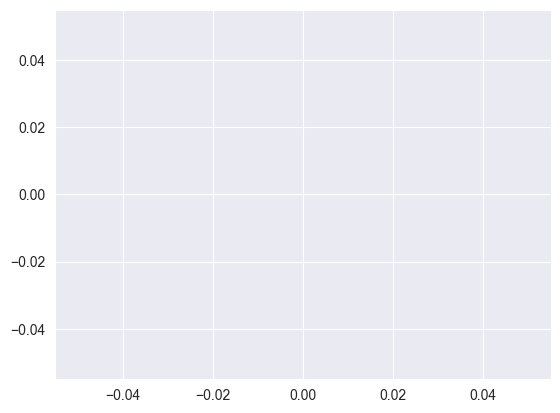

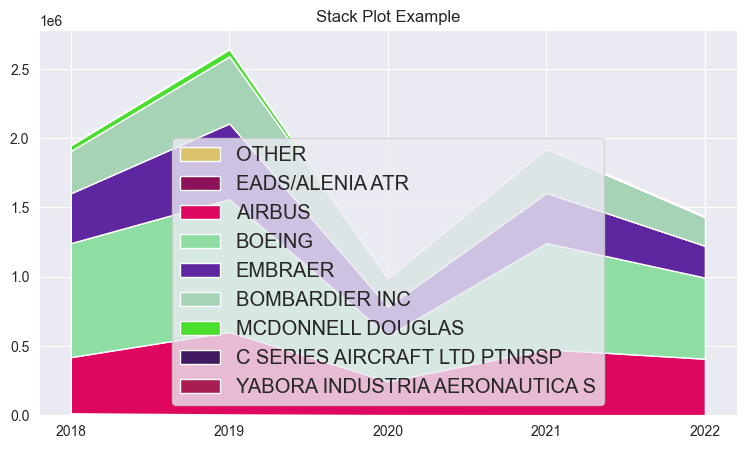

In [62]:
idxes = [2018, 2019, 2020, 2021, 2022]
data = pd.DataFrame.from_dict(stack_plot_data, orient='index')
print(data)

__colours = [[random.random(),random.random(),random.random()] for _ in range(len(stack_plot_data.keys()))]
print(__colours)

i = 0
for mfr, row in data.iterrows():
	plt.plot([], [], color=__colours[i], label=str(mfr))
	i += 1

__data = [row.values.tolist() for _, row in data.iterrows()]
print(__data)

px = 1/plt.rcParams['figure.dpi']  # pixel in inches
plt.subplots(figsize=(900*px, 500*px))
plt.stackplot(np.asarray(idxes, int), __data, colors=__colours)
plt.title('Stack Plot Example')
plt.legend(stack_plot_data.keys(), fontsize="x-large")
plt.xticks(idxes)
plt.show()